# 04 - Time Series Forecasting - Data Review in BigQuery


### Prerequisites:
-  00 - Environment Setup

### Overview:
- Setup
- Data Setup
- Propose Train/Validation/Test Splits by Date Range
- Create Source BigQuery Table for Forecasting
- Review Forecasting Data
- Validation Check: Extract dates for splits from source
- Validation Check: Duplicate dates at stations?
- Time Series Review

### Resources:
- [How to do time series forecasting in BigQuery](https://towardsdatascience.com/how-to-do-time-series-forecasting-in-bigquery-af9eb6be8159)

---
## Vertex AI - Conceptual Flow

<img src="architectures/slides/04_arch.png">

---
## Vertex AI - Workflow

<img src="architectures/slides/04_console.png">

---
## Setup

inputs:

In [2]:
PROJECT_ID='statmike-demo3'
REGION = 'us-central1'
DATANAME = 'citibikes'
NOTEBOOK = '04'

BQ_SOURCE = 'bigquery-public-data.new_york.citibike_trips'

packages:

In [3]:
from google.cloud import bigquery
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

clients:

In [4]:
bigquery = bigquery.Client()

---
## Data Setup

### Create BigQuery Dataset
Create a BigQuery Dataset within this project:

In [5]:
query = f"""
CREATE SCHEMA IF NOT EXISTS `{PROJECT_ID}.{DATANAME}`
OPTIONS(
    location = 'US',
    labels = [('notebook','{NOTEBOOK}')]
)
"""
job = bigquery.query(query = query)
job.result()

### Review Source Data
Stored in BigQuery Public Datasets

Quick Preview:

In [7]:
query = f"""
SELECT * 
FROM `{BQ_SOURCE}`
LIMIT 5
"""
preview = bigquery.query(query = query).to_dataframe()
preview

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,10274,2016-04-24 22:36:40+00:00,2016-04-25 01:27:54+00:00,263,Elizabeth St & Hester St,40.717290,-73.996375,3240,NYCBS Depot BAL - DYR,0.000000,0.000000,16458,Customer,NaN,unknown
1,111769,2016-02-08 19:27:15+00:00,2016-02-10 02:30:04+00:00,249,Harrison St & Hudson St,40.718710,-74.009001,3240,NYCBS Depot BAL - DYR,0.000000,0.000000,16860,Subscriber,1966.0,male
2,547,2016-05-02 17:52:21+00:00,2016-05-02 18:01:29+00:00,514,12 Ave & W 40 St,40.760875,-74.002777,3240,NYCBS Depot BAL - DYR,0.000000,0.000000,22094,Subscriber,1975.0,male
3,152978,2016-02-22 19:22:07+00:00,2016-02-24 13:51:46+00:00,250,Lafayette St & Jersey St,40.724561,-73.995653,3019,NYCBS Depot - DEL,40.716633,-73.981933,17943,Subscriber,1969.0,male
4,100569,2015-12-17 10:24:19+00:00,2015-12-18 14:20:29+00:00,417,Barclay St & Church St,40.712912,-74.010202,3019,NYCBS Depot - DEL,40.716633,-73.981933,22674,Subscriber,1989.0,male


Quick Summary of Stations Near Central Park:

In [9]:
query = f"""
WITH TRIPS AS(
    SELECT
       start_station_name,
       EXTRACT(DATE from starttime) AS date,
       COUNT(*) AS num_trips
    FROM `{BQ_SOURCE}`
    WHERE start_station_name LIKE '%Central Park%'
    GROUP BY start_station_name, date
)
SELECT start_station_name, sum(num_trips) as total_trips, min(date) as FromDate, max(date) as ToDate
FROM TRIPS
GROUP BY start_station_name
ORDER BY start_station_name
"""
overview = bigquery.query(query = query).to_dataframe()
overview

,start_station_name,total_trips,FromDate,ToDate
0,Central Park North & Adam Clayton Powell Blvd,4808,2016-09-01,2016-09-30
1,Central Park S & 6 Ave,172220,2013-07-01,2016-09-30
2,Central Park W & W 96 St,5905,2016-08-04,2016-09-30
3,Central Park West & W 100 St,2245,2016-08-08,2016-09-30
4,Central Park West & W 102 St,2851,2016-08-08,2016-09-30
5,Central Park West & W 68 St,35192,2015-09-01,2016-09-30
6,Central Park West & W 72 St,44574,2015-09-01,2016-09-30
7,Central Park West & W 76 St,27919,2015-09-09,2016-09-30
8,Central Park West & W 85 St,43895,2015-10-07,2016-09-23
9,Grand Army Plaza & Central Park S,163815,2013-07-01,2016-09-30


Visualize each stations data time range:

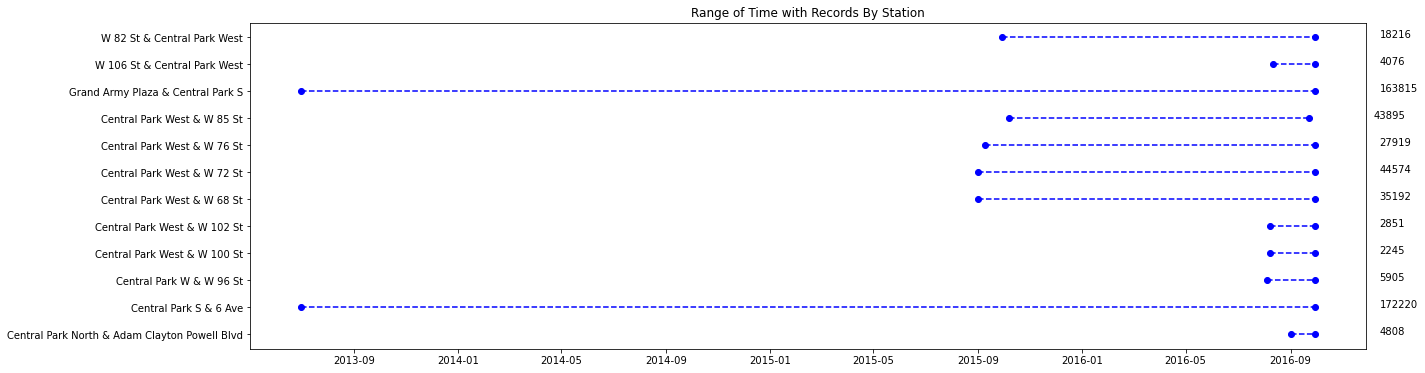

In [11]:
plt.figure(figsize=(20,6))
for i in range(len(overview)):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview['start_station_name'][i], overview['start_station_name'][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    plt.text(x[1]+timedelta(75), y[0], str(overview['total_trips'][i]))
    plt.title('Range of Time with Records By Station')
plt.show()

## Propose Train/Validation/Test Splits by Date Range

Get key dates from the Central Park area stations data:
- Using 1.25% of date range as test data
- Using 97.5%-98.75% of date range as validation data (when method needs it - otherwise, will be training data
- Using first 95.5% of date range as test data

In [12]:
query = f"""
WITH
    ALLDATES AS(
        SELECT EXTRACT(DATE from starttime) as date
        FROM `{BQ_SOURCE}`
        WHERE start_station_name LIKE '%Central Park%'
    ),
    KEYS AS(
        SELECT 
            MIN(date) as start_date,
            MAX(date) - CAST(0.025 * DATE_DIFF(MAX(date), MIN(date), DAY) AS INT64) as val_start,
            MAX(date) - CAST(0.0125 * DATE_DIFF(MAX(date), MIN(date), DAY) AS INT64) test_start,
            MAX(date) as end_date
        FROM ALLDATES  
    )
SELECT *, DATE_DIFF(end_date, test_start, DAY)+1 as forecast_horizon
FROM KEYS
"""
keyDates = bigquery.query(query = query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date,forecast_horizon
0,2013-07-01,2016-08-31,2016-09-15,2016-09-30,16


Visualize each stations data time range with proposed data segments from key dates:

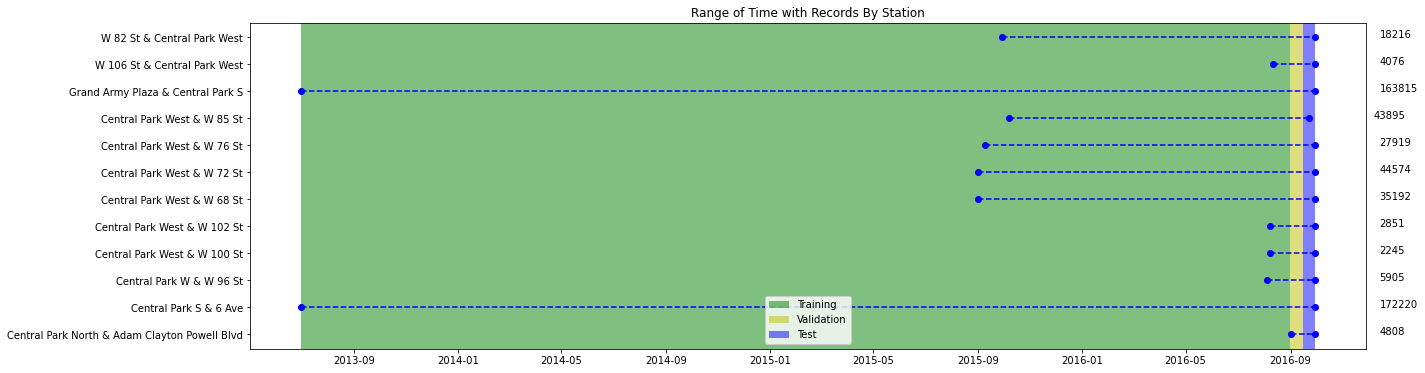

In [14]:
plt.figure(figsize=(20,6))
for i in range(len(overview)):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview['start_station_name'][i], overview['start_station_name'][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    plt.text(x[1]+timedelta(75), y[0], str(overview['total_trips'][i]))
    plt.title('Range of Time with Records By Station')
plt.axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.5, label = 'Training')
plt.axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.5, label = 'Validation')
plt.axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.5, label = 'Test')
plt.legend(loc = 'lower center')
plt.show()

## Create Source BigQuery Table for Forecasting

In [15]:
query = f"""
CREATE OR REPLACE TABLE `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped` AS
WITH
    DAYS AS(
        SELECT
           start_station_name,
           EXTRACT(DATE from starttime) AS date,
           COUNT(*) AS num_trips
        FROM `{BQ_SOURCE}`
        WHERE start_station_name LIKE '%Central Park%'
        GROUP BY start_station_name, date
    )
SELECT *,
   CASE
       WHEN date < DATE({keyDates['val_start'][0].strftime('%Y, %m, %d')}) THEN "TRAIN"
       WHEN date < DATE({keyDates['test_start'][0].strftime('%Y, %m, %d')}) THEN "VALIDATE"
       ELSE "TEST"
   END AS splits
FROM DAYS
"""
job = bigquery.query(query = query)
job.result()
(job.ended-job.started).total_seconds()

1.644

## Review Forecasting Data

In [16]:
query = f"""
SELECT 
    start_station_name,
    COUNTIF(splits='TRAIN') as TRAIN,
    COUNTIF(splits='VALIDATE') as VALIDATE,
    COUNTIF(splits='TEST') as TEST,
    sum(num_trips) as totalTrips
FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
GROUP BY start_station_name
ORDER BY start_station_name
"""
splitCounts = bigquery.query(query = query).to_dataframe()
splitCounts

,start_station_name,TRAIN,VALIDATE,TEST,totalTrips
0,Central Park North & Adam Clayton Powell Blvd,0,14,16,4808
1,Central Park S & 6 Ave,1146,15,16,172220
2,Central Park W & W 96 St,27,15,16,5905
3,Central Park West & W 100 St,23,15,16,2245
4,Central Park West & W 102 St,23,15,16,2851
5,Central Park West & W 68 St,328,15,16,35192
6,Central Park West & W 72 St,331,15,15,44574
7,Central Park West & W 76 St,324,15,16,27919
8,Central Park West & W 85 St,321,15,9,43895
9,Grand Army Plaza & Central Park S,1149,15,15,163815


Totals by data split:

In [54]:
splitCounts[['TRAIN','TEST','VALIDATE']].sum()

TRAIN       4020
TEST         183
VALIDATE     179
dtype: int64

Overall total:

In [17]:
splitCounts[['TRAIN','TEST','VALIDATE']].sum().sum()

4382

Visualize days of data available for forecasting at each station:

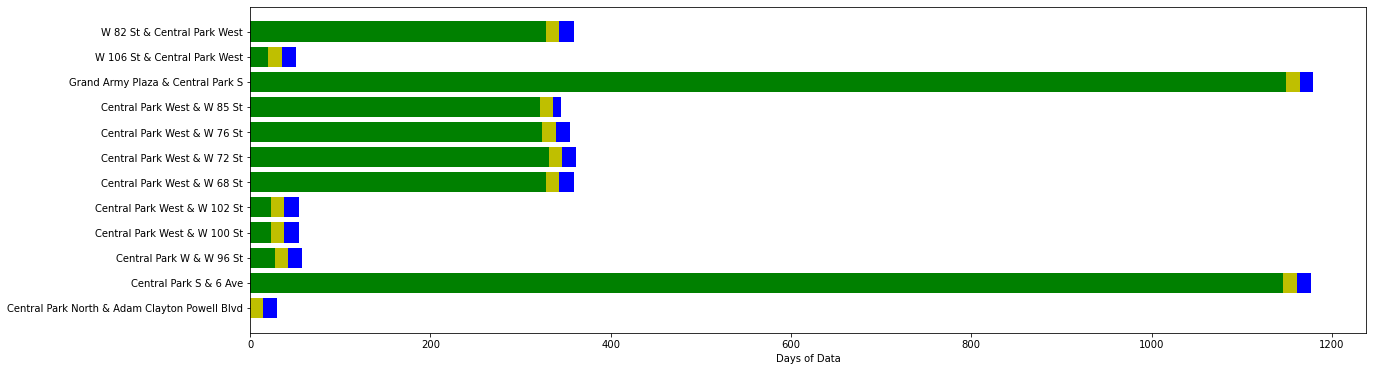

In [18]:
plt.figure(figsize=(20,6))
plt.barh(splitCounts['start_station_name'], splitCounts['TRAIN'], color = 'g')
plt.barh(splitCounts['start_station_name'], splitCounts['VALIDATE'], color = 'y', left = splitCounts['TRAIN'])
plt.barh(splitCounts['start_station_name'], splitCounts['TEST'], color = 'b', left = splitCounts['TRAIN']+splitCounts['VALIDATE'])
plt.xlabel('Days of Data')
plt.show()

## Validation Check: Extract dates for splits from source

In [30]:
query = f"""
WITH
    SPLIT AS (
        SELECT splits, min(date) as mindate, max(date) as maxdate
        FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
        GROUP BY splits
    ),
    TRAIN AS (
        SELECT mindate as start_date
        FROM SPLIT
        WHERE splits ='TRAIN'
    ),
    VAL AS (
        SELECT mindate as val_start
        FROM SPLIT
        WHERE splits = 'VALIDATE'
    ),
    TEST AS (
        SELECT mindate as test_start, maxdate as end_date, DATE_DIFF(maxdate, mindate, DAY)+1 as forecast_horizon
        FROM SPLIT
        WHERE splits = 'TEST'
    )
SELECT * EXCEPT(pos) FROM
(SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
USING (pos)
JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
USING (pos)
"""
keyDates = bigquery.query(query = query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date,forecast_horizon
0,2013-07-01,2016-08-31,2016-09-15,2016-09-30,16


## Validation Check: Duplicate Dates at Stations?
Are there any stations with data for duplicate dates?

In [19]:
query = f"""
WITH
    DAYS AS (
        SELECT start_station_name, date, count(*) as records
        FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
        GROUP BY start_station_name, date
    )
SELECT *
FROM DAYS
WHERE records > 1
"""
bigquery.query(query = query).to_dataframe()

,start_station_name,date,records


## Time Series Review

In [20]:
query = f"""
SELECT 
    start_station_name, date, splits, sum(num_trips) as num_trips
FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
GROUP BY start_station_name, date, splits
ORDER by start_station_name, date
"""
rawSeries = bigquery.query(query = query).to_dataframe()

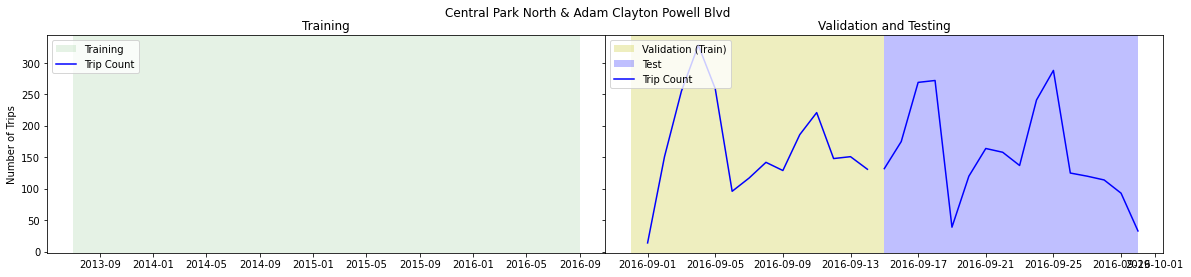

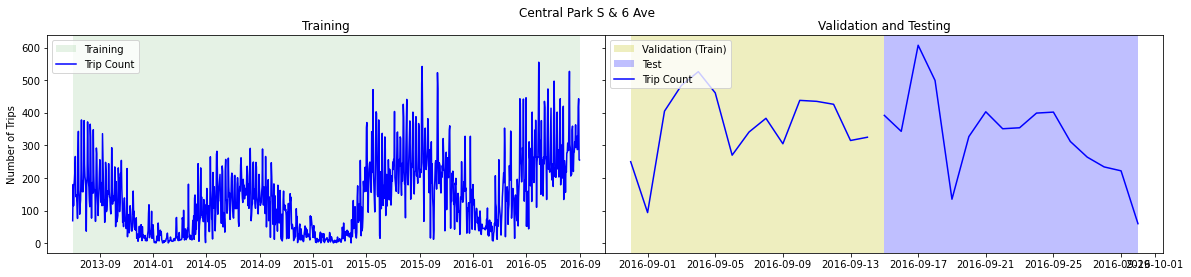

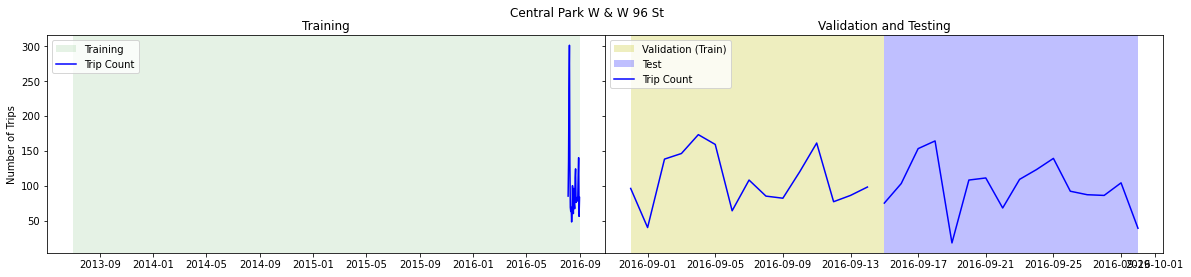

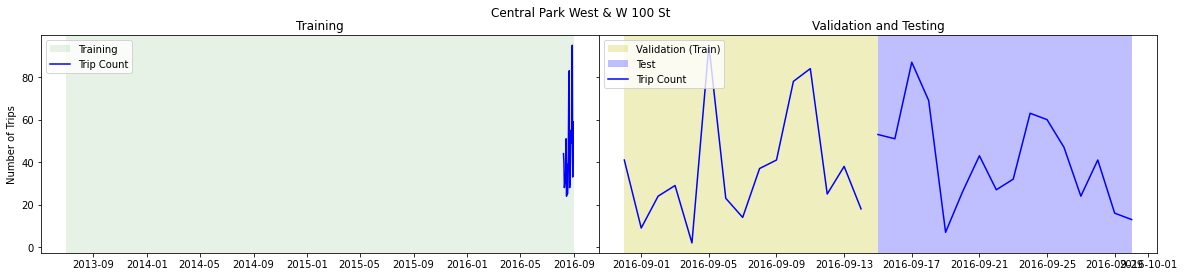

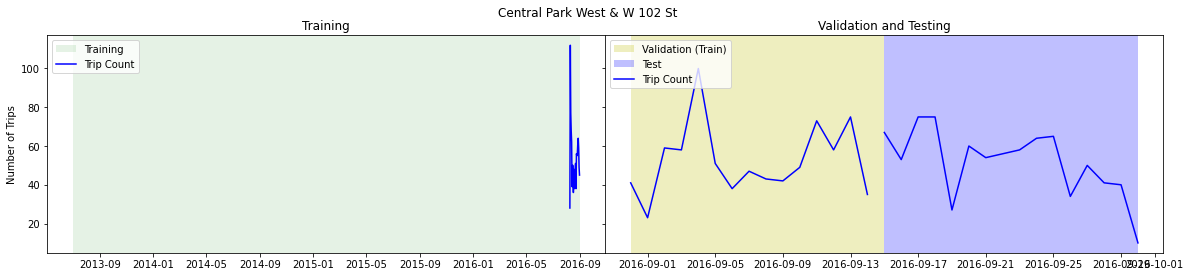

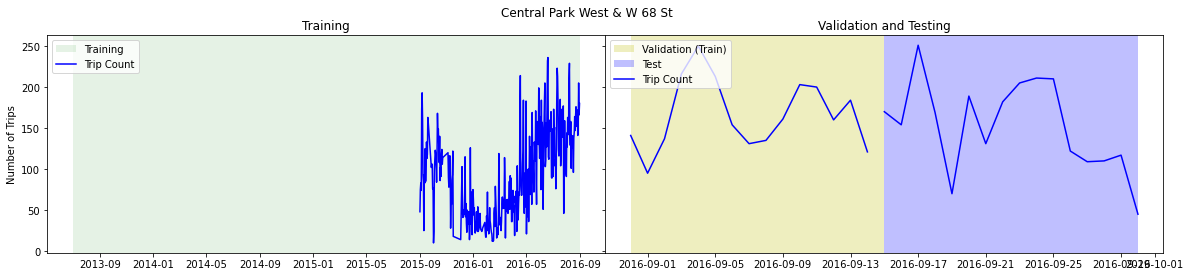

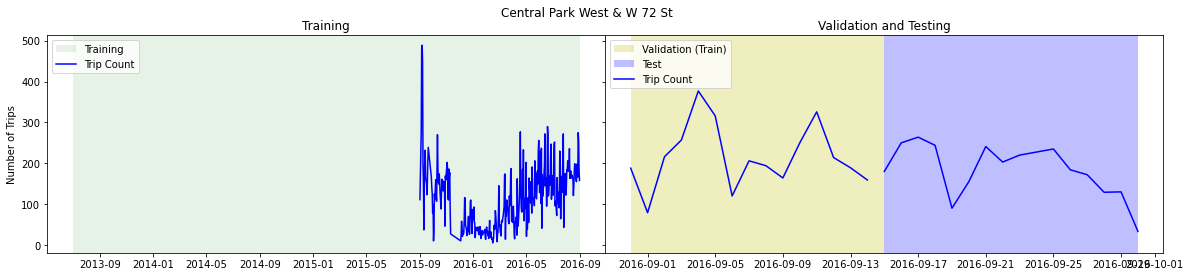

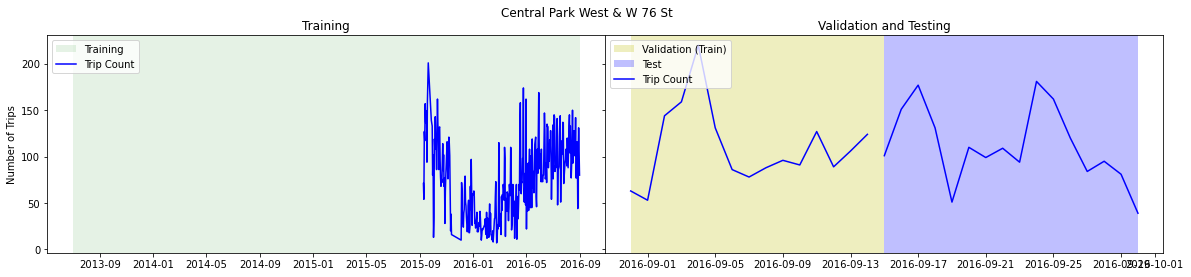

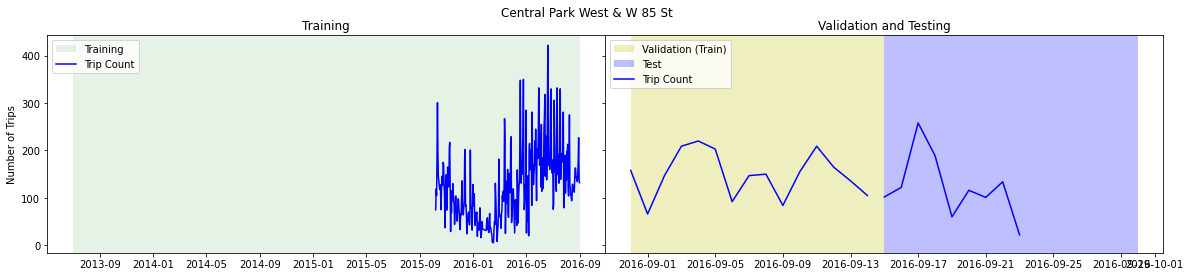

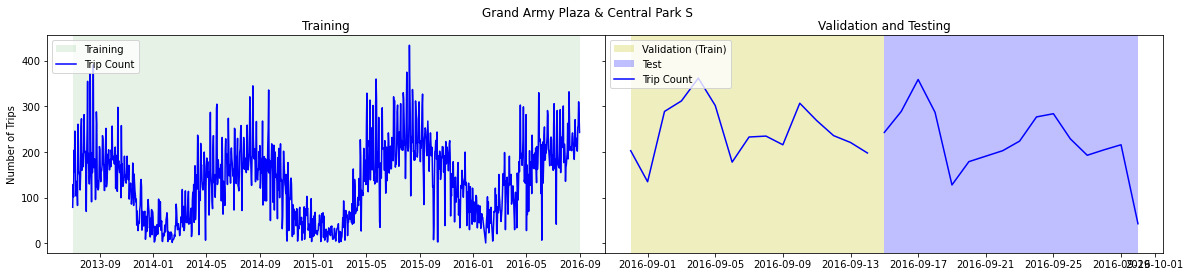

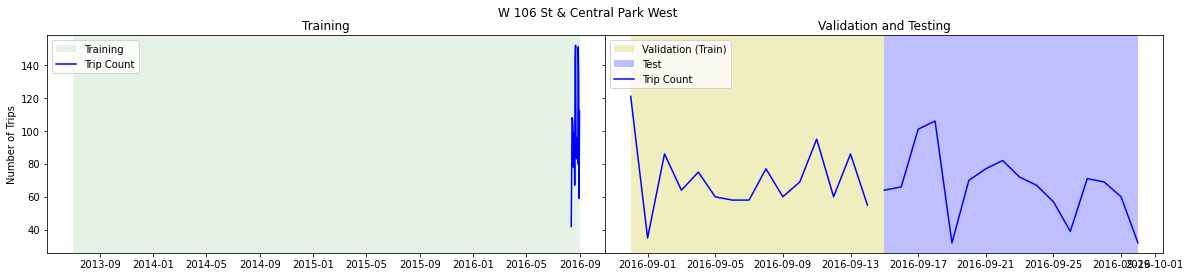

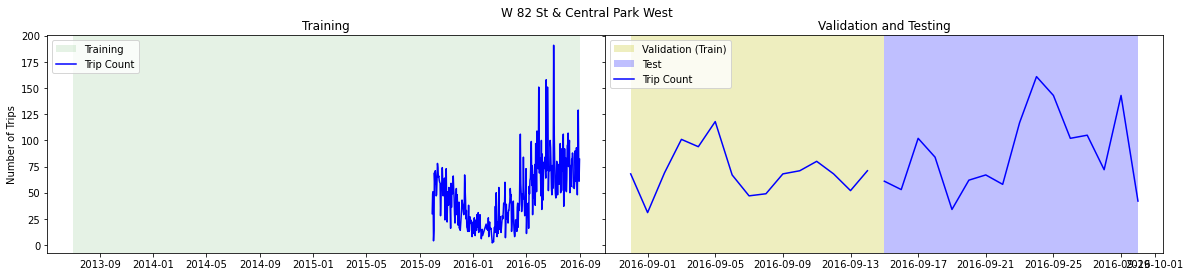

In [21]:
stations = rawSeries['start_station_name'].unique().tolist()
for s, st in enumerate(stations):
    # setup plot area
    fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
    fig.subplots_adjust(wspace=0)
    
    # data
    traindf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'TRAIN')]
    valdf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'VALIDATE')]
    testdf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'TEST')]
    
    # regions
    axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
    axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
    axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
    
    # lines and dots
    axes[0].plot(traindf['date'], traindf['num_trips'], color = 'b', label = 'Trip Count')
    axes[1].plot(valdf['date'], valdf['num_trips'], color = 'b', label = 'Trip Count')
    axes[1].plot(testdf['date'], testdf['num_trips'], color = 'b')
    
    # labels
    axes[0].set_ylabel('Number of Trips')
    axes[0].set_title('Training')
    axes[1].set_title('Validation and Testing')
    axes[1].legend(loc = 'upper left')
    axes[0].legend(loc = 'upper left')
    plt.suptitle(st)

    # display result
    plt.show()

---
## Remove Resources
see notebook "99 - Cleanup"